## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib

In [4]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14.0, 8.7)

In [5]:
pyLDAvis.enable_notebook()

In [6]:
# change to your data path if necessary
DATA_DIR = Path('../data')
data_path = DATA_DIR / 'bbc'

In [7]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

## Load BBC data

Using the BBC data as before, we use [sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to train an LDA model with five topics.

In [8]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [9]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [10]:
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.topic,
                                         test_size=125,
                                         random_state=42)

In [11]:
train_docs.shape, test_docs.shape

((2100, 3), (125, 3))

In [12]:
pd.Series(test_docs.topic).value_counts()

topic
Sport            29
Business         29
Politics         23
Tech             22
Entertainment    22
Name: count, dtype: int64

### Vectorize train & test sets

In [14]:
# experiments with different settings results yields the following hyperparameters (see issue 50)
vectorizer = TfidfVectorizer(max_df=.11, 
                             min_df=.026, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names_out()
train_dtm

<2100x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 113356 stored elements in Compressed Sparse Row format>

In [15]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<125x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 6779 stored elements in Compressed Sparse Row format>

## LDA with sklearn

In [16]:
n_components = 5
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]

In [17]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

### Persist model

The model tracks the in-sample perplexity during training and stops iterating once this measure stops improving. We can persist and load the result as usual with sklearn objects:

In [18]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

['results/bbc/lda_10_iter.pkl']

In [19]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(n_components=5, n_jobs=-1)

## Explore topics & word distributions

In [20]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 1097)


array([[1.23234196, 4.52274255, 4.03159183, ..., 0.68920384, 5.86320397,
        5.17687278],
       [3.98424296, 5.83695401, 6.29791985, ..., 0.21211159, 4.97557415,
        0.33911393],
       [1.47595414, 2.66822486, 3.78981798, ..., 2.32695804, 1.74247909,
        4.70565014],
       [3.87743969, 2.66375667, 2.13546948, ..., 6.10241911, 0.47427284,
        4.74905605],
       [3.96768836, 1.38342556, 3.2479736 , ..., 1.02530278, 2.84803304,
        1.22940189]])

In [21]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
100,0.000713,0.001353,0.000482,0.001165,0.001531
11,0.002617,0.001982,0.000872,0.000800,0.000534
12,0.002332,0.002139,0.001239,0.000642,0.001253
13,0.001984,0.001117,0.001303,0.000265,0.000523
14,0.001225,0.001109,0.001033,0.000743,0.000661


In [22]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

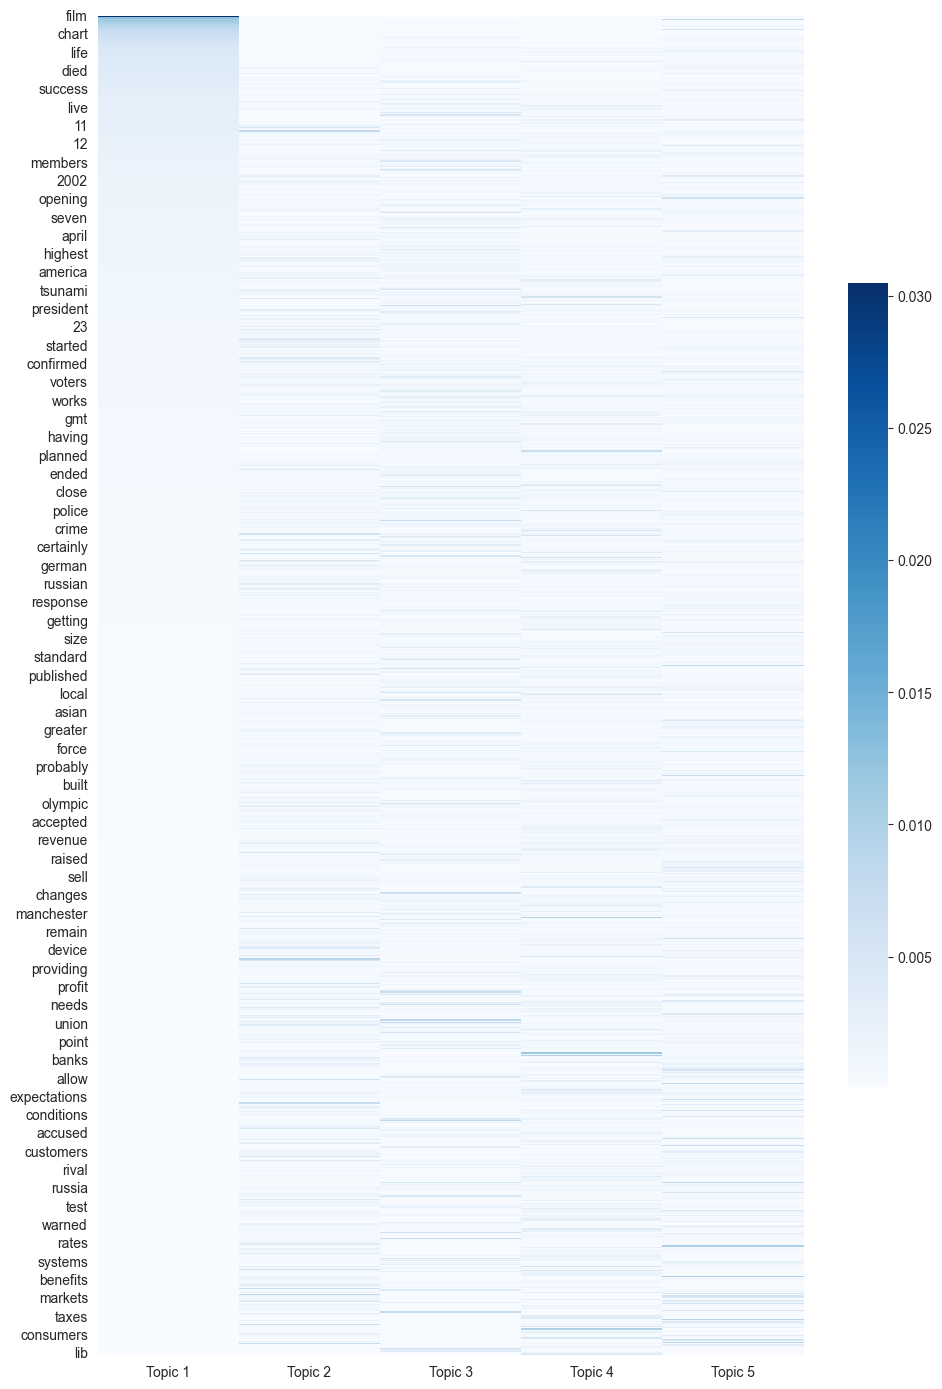

In [23]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(topics.sort_values(topic_labels, ascending=False),
            cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

In [24]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,film,bank,club,labour,mobile
1,awards,growth,team,blair,technology
2,award,sales,match,election,software
3,music,economy,cup,party,users
4,band,shares,season,brown,digital
5,star,oil,injury,law,computer
6,album,china,final,howard,music
7,actor,economic,ireland,court,games
8,films,prices,chelsea,prime,online
9,singer,deal,coach,secretary,phone


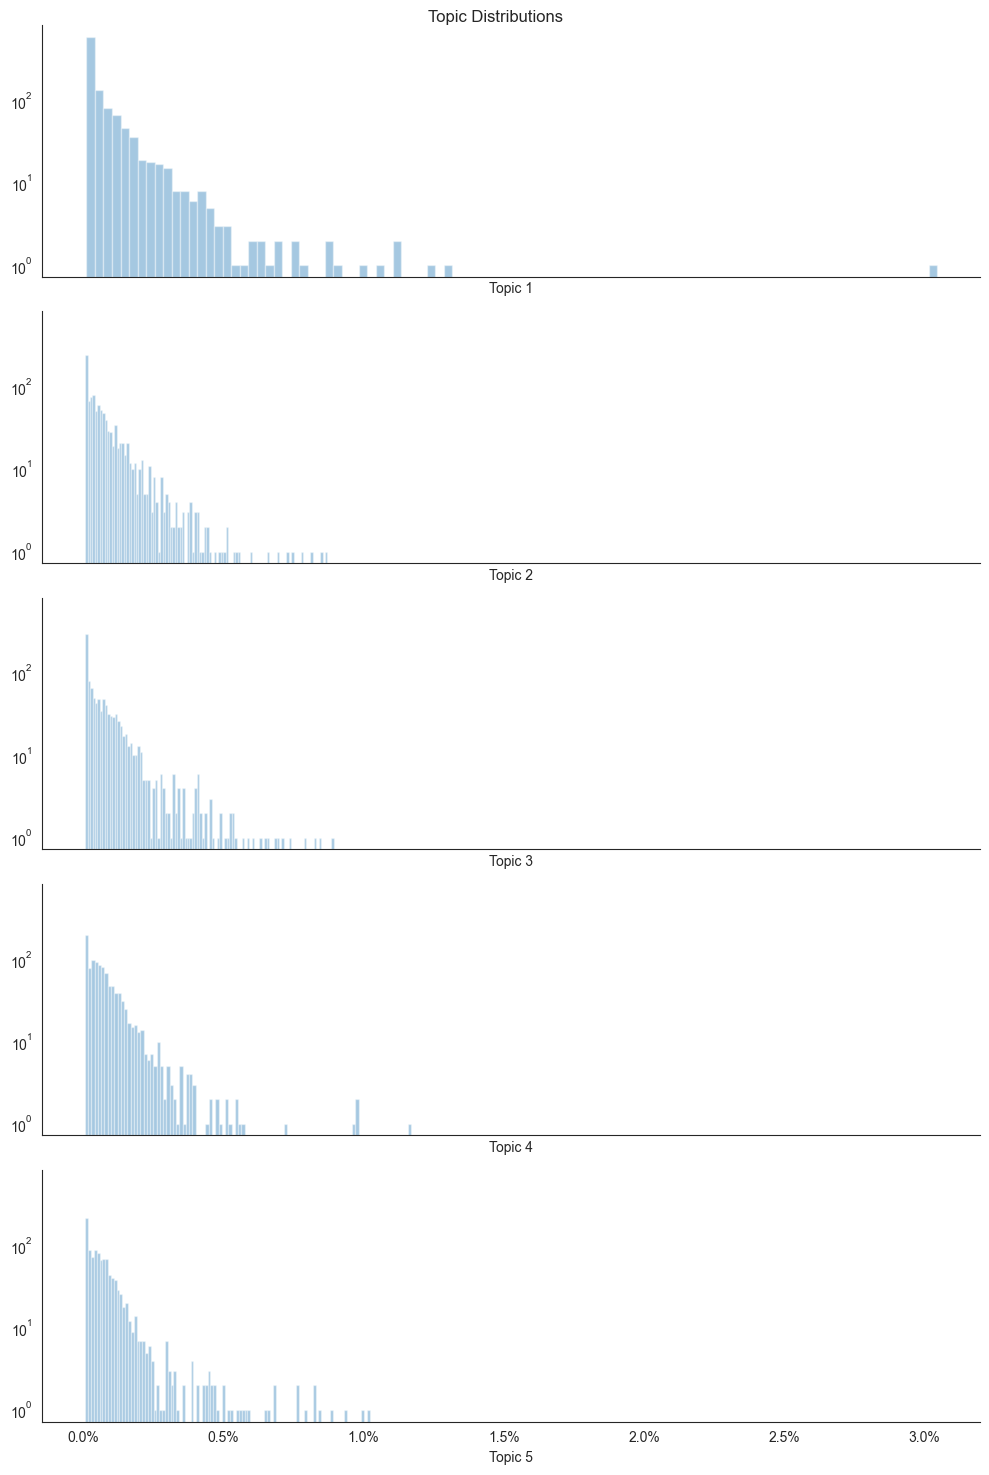

In [25]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

## Evaluate Fit on Train Set

In [26]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2100, 5)

In [27]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Sport,0.029646,0.029689,0.881245,0.029827,0.029593
Tech,0.031460,0.031009,0.030505,0.032787,0.874239
Politics,0.021022,0.021011,0.021201,0.915531,0.021236
Sport,0.041010,0.041037,0.835714,0.041269,0.040970
Tech,0.041994,0.030439,0.080103,0.029798,0.817665


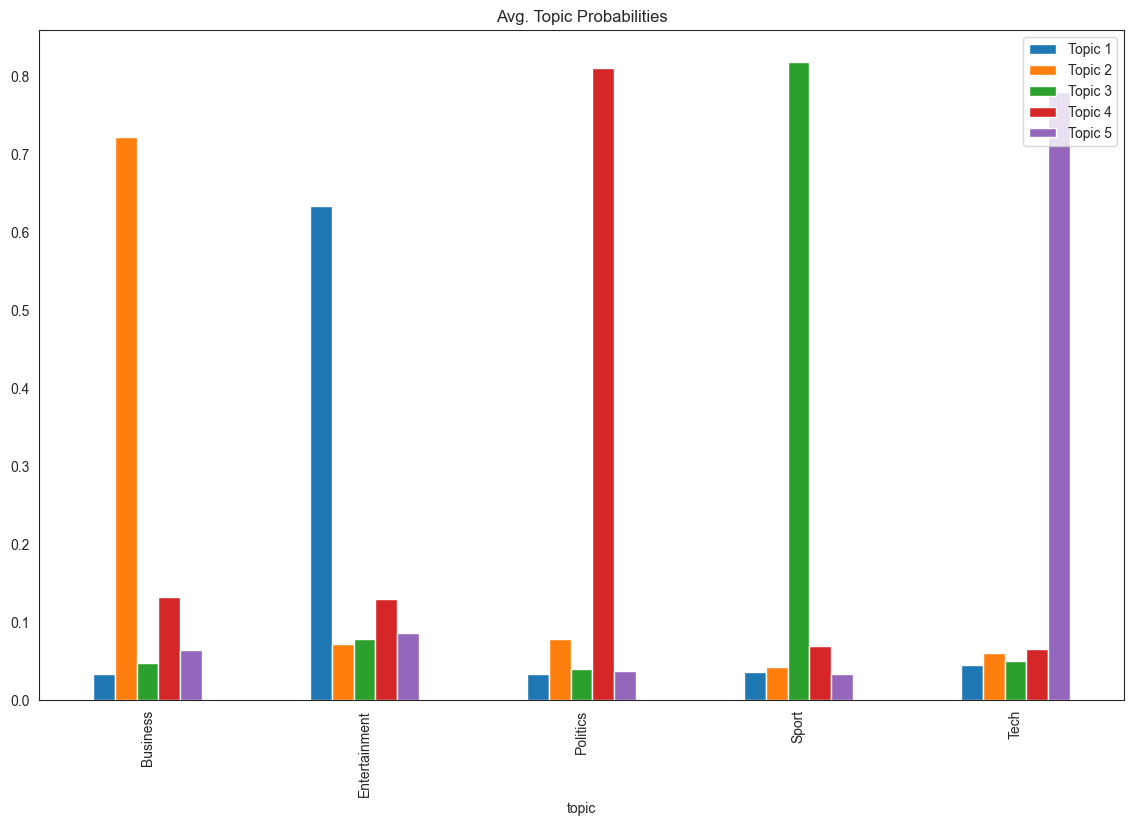

In [28]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

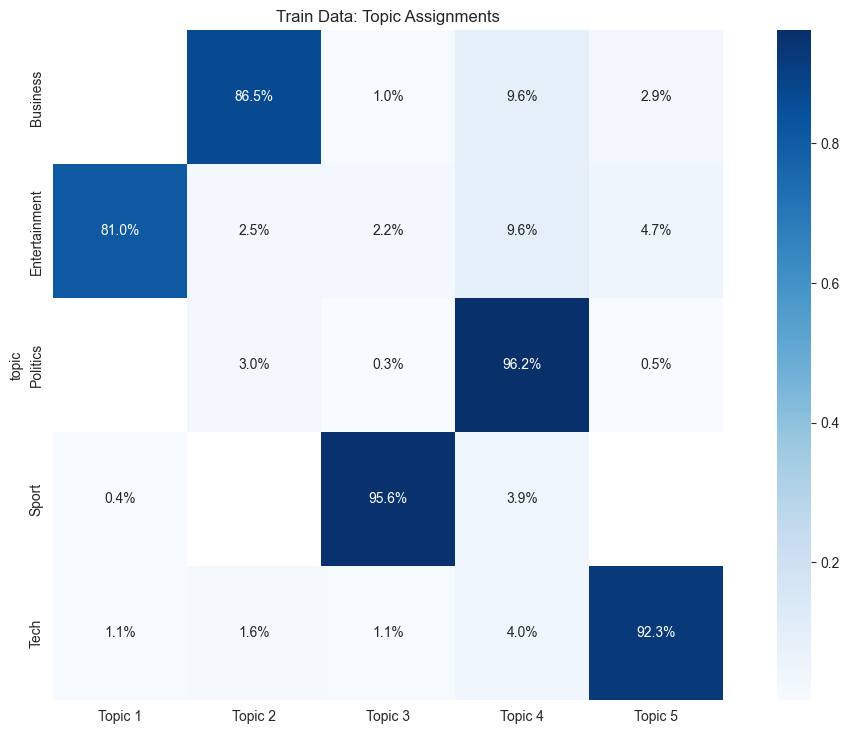

In [29]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

## Evaluate Fit on Test Set 

In [30]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Politics,0.025357,0.025267,0.027173,0.896812,0.025393
Sport,0.037357,0.035921,0.563983,0.326120,0.036620
Business,0.031720,0.833163,0.070627,0.031839,0.032652
Business,0.032493,0.868808,0.035950,0.031125,0.031624
Tech,0.030103,0.275221,0.030553,0.030156,0.633967


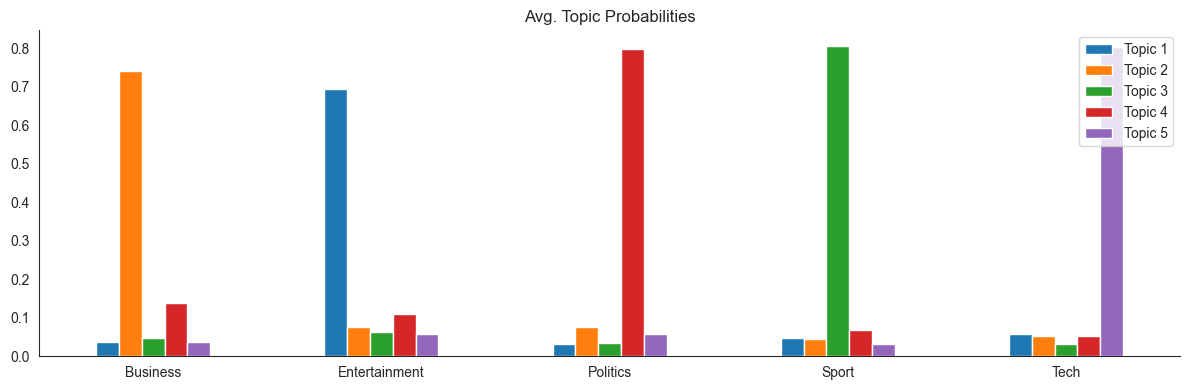

In [31]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities',
                                                 figsize=(12, 4),
                                                 rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

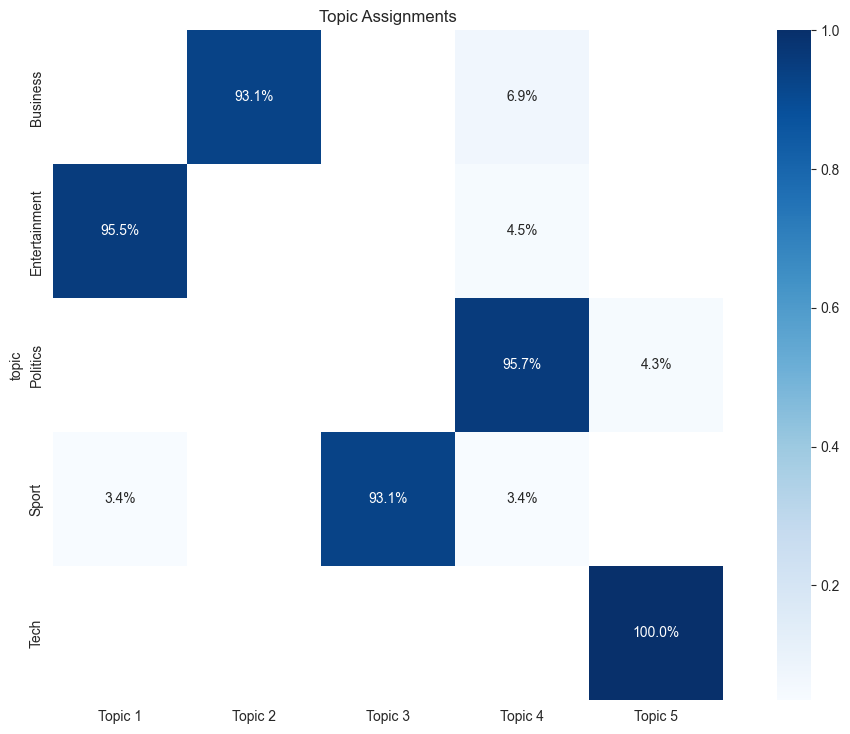

In [32]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1), 
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

## Retrain until perplexity no longer decreases

In [33]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    n_jobs=-1,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1985.9009
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1900.6394
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1887.4267
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1875.6741
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1860.5418
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [34]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results/bbc/lda_opt.pkl']

In [35]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [36]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [37]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

## Compare Train & Test Topic Assignments 

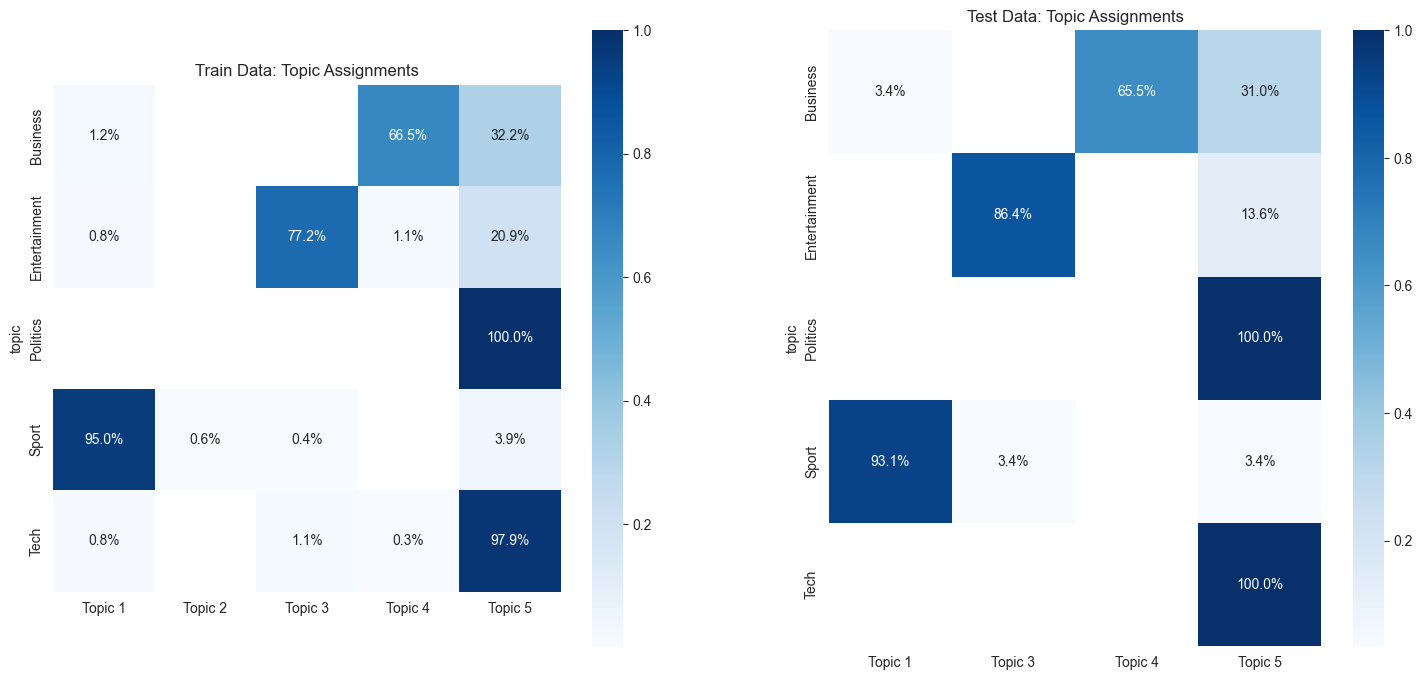

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
                .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))

## Explore misclassified articles 

In [39]:
test_assignments = test_docs.assign(predicted=test_opt_eval.idxmax(axis=1).values)
test_assignments.head()

,topic,heading,article,predicted
1006,Politics,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP R...,Topic 5
1358,Sport,Radcliffe eyes hard line on drugs,Paula Radcliffe has called for all athletes f...,Topic 1
71,Business,S Korean consumers spending again,South Korea looks set to sustain its revival ...,Topic 4
372,Business,Quiksilver moves for Rossignol,"Shares of Skis Rossignol, the world's largest...",Topic 4
2151,Tech,Britons fed up with net service,A survey conducted by PC Pro Magazine has rev...,Topic 5


In [40]:
misclassified = test_assignments[(test_assignments.topic == 'Entertainment') & (
    test_assignments.predicted == 'Topic 4')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [41]:
misclassified.article.tolist()

[]

## PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

Topic visualization facilitates the evaluation of topic quality using human judgment. pyLDAvis is a python port of LDAvis, developed in R and D3.js. We will introduce the key concepts; each LDA implementation notebook contains examples.

pyLDAvis displays the global relationships among topics while also facilitating their semantic evaluation by inspecting the terms most closely associated with each individual topic and, inversely, the topics associated with each term. It also addresses the challenge that terms that are frequent in a corpus tend to dominate the multinomial distribution over words that define a topic. LDAVis introduces the relevance r of term w to topic t to produce a flexible ranking of key terms using a weight parameter 0<=ƛ<=1. 

With $\phi_{wt}$  as the model’s probability estimate of observing the term w for topic t, and   as the marginal probability of w in the corpus:
$$r(w, k | \lambda) = \lambda \log(\phi_{kw}) + (1 − \lambda) \log \frac{\phi_{kw}}{p_w}$$

The first term measures the degree of association of term t with topic w, and the second term measures the lift or saliency, i.e., how much more likely the term is for the topic than in the corpus. 

The tool allows the user to interactively change ƛ to adjust the relevance, which updates the ranking of terms. User studies have found that ƛ=0.6 produces the most plausible results. 

## Refit using all data

In [42]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [43]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.9467
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1006.8139
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1615
iteration:

LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [44]:
joblib.dump(lda_all, model_path /'lda_all.pkl')

['results/bbc/lda_all.pkl']

In [45]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [62]:
prepare(lda_all, dtm, vectorizer)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

## Topics as WordClouds

In [54]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names_out(),
                      columns=topic_labels)

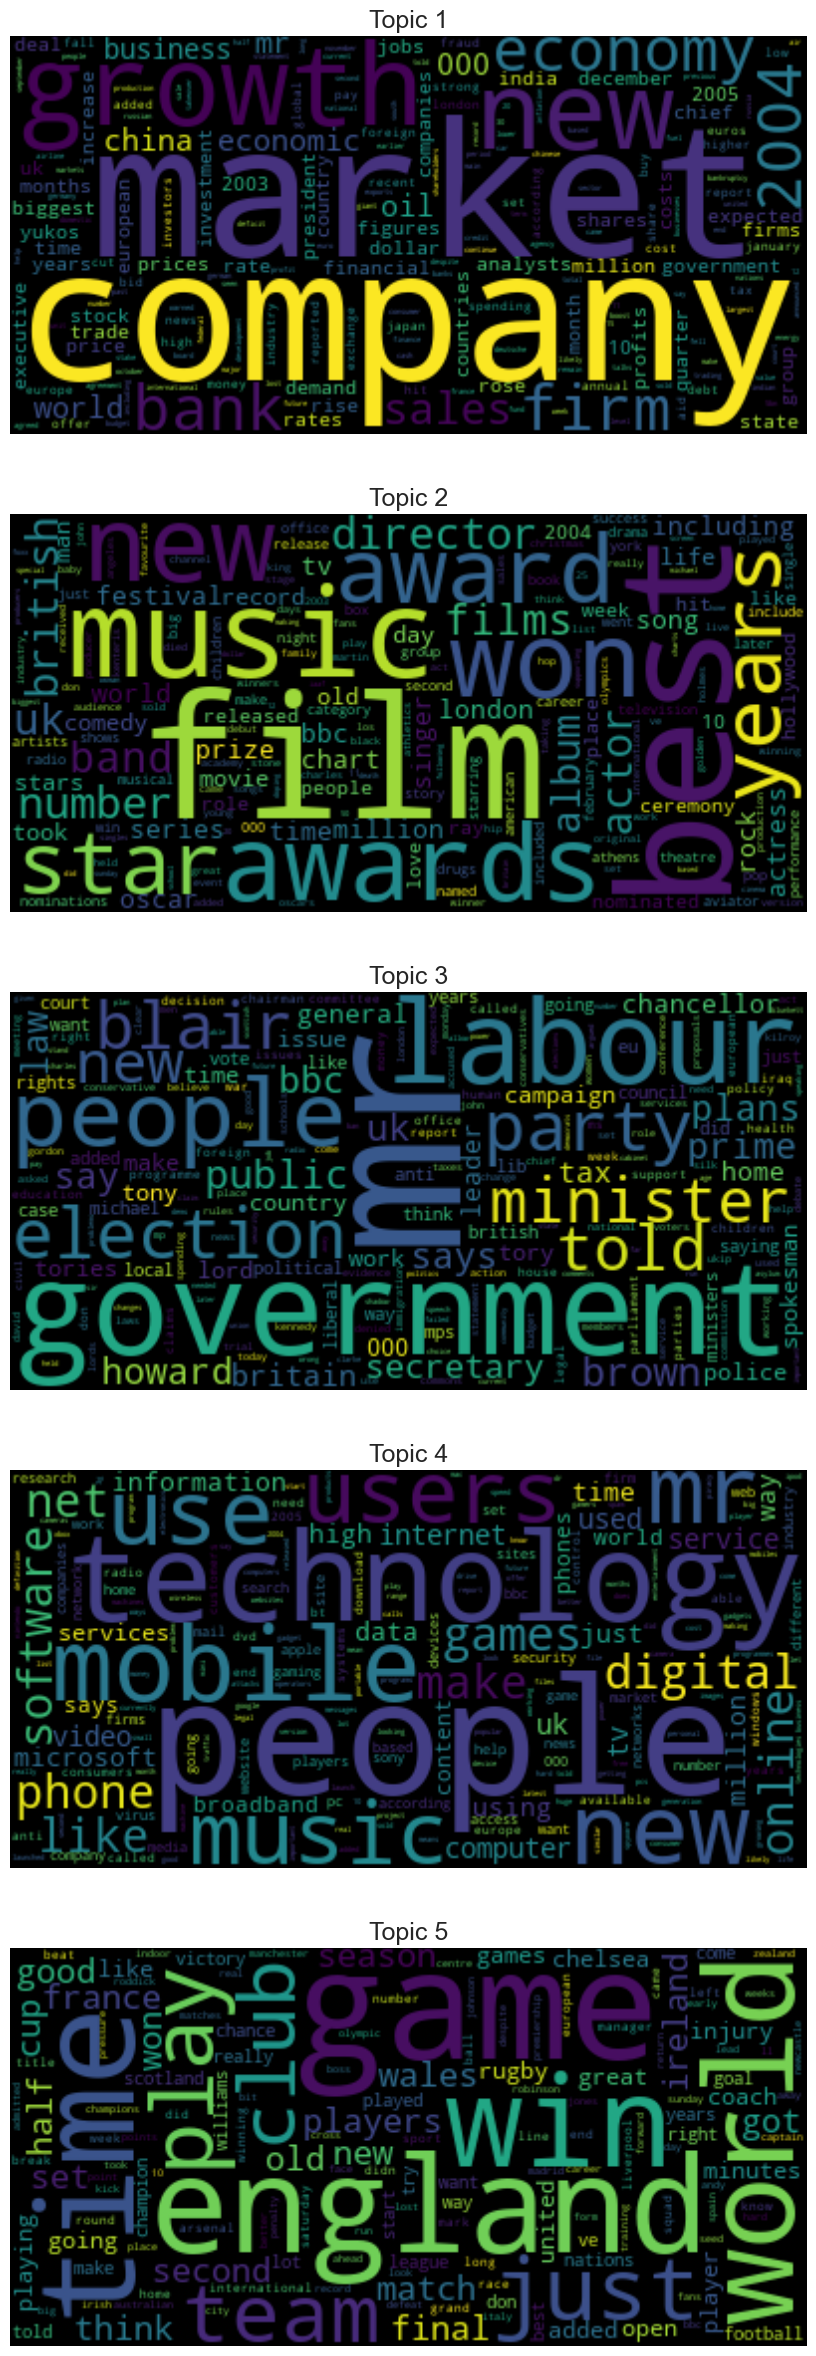

In [55]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [56]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [57]:
dtm_.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.757415,0.043291,0.001399,0.196532,0.001363
Business,0.936017,0.001356,0.059912,0.001354,0.001361
Business,0.976877,0.017347,0.001937,0.001917,0.001922
Business,0.994521,0.001373,0.001363,0.001368,0.001375
Business,0.989023,0.002714,0.002762,0.002725,0.002775


In [58]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [59]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.05).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Business,0.630684,0.114709,0.128678,0.065489,0.060440,One of Japan's best-known businessmen was arr...,Japanese mogul arrested for fraud
Entertainment,0.064855,0.319108,0.084398,0.225091,0.306548,Broadcaster Chris Evans has begun selling tho...,Chris Evans back on the market
Entertainment,0.055545,0.168249,0.363690,0.284121,0.128394,Angolan families who are attempting to track ...,TV show unites Angolan families
Entertainment,0.051780,0.742649,0.069040,0.065869,0.070662,"Scottish rock band Franz Ferdinand, who shot ...",Franz Ferdinand's art school lesson
Entertainment,0.229219,0.199995,0.417789,0.070954,0.082044,Proposals to open a museum dedicated to Jimi ...,Row threatens Hendrix museum plan
Entertainment,0.100635,0.634550,0.154238,0.055561,0.055016,"Stan Lee, the man responsible for a string of...",The comic book genius of Stan Lee
Entertainment,0.144835,0.280651,0.232055,0.230626,0.111833,Women in the UK film industry earn less than ...,Women in film 'are earning less'
Tech,0.291468,0.073499,0.108780,0.465605,0.060647,Car-maker Honda's humanoid robot Asimo has ju...,Humanoid robot learns how to run


In [60]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Japanese mogul arrested for fraud 

One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data. Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo. There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the shar